In [1]:
import os
import time
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import math

import json as JS
from json import load
from json import loads
from datetime import datetime

from pmdarima.arima import auto_arima
import statsmodels.api as sm
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas.io.json import json_normalize
from pandas.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters
from prometheus_api_client import Metric, MetricsList, PrometheusConnect
from prometheus_api_client.utils import parse_datetime, parse_timedelta

# Data Preparation

raw_data = pd.read_json("201909031209.json")
raw_data.head()

,metric,values
0,"{'__name__': 'badger_disk_reads:rate1m', 'ae_s...","[[1567095000.825, 0], [1567095060.825, 0], [15..."
1,"{'__name__': 'badger_disk_reads:rate1m', 'ae_s...","[[1567095000.825, 0], [1567095060.825, 0], [15..."
2,"{'__name__': 'badger_disk_reads:rate1m', 'ae_s...","[[1567095000.825, 0], [1567095060.825, 0], [15..."
3,"{'__name__': 'badger_disk_reads:rate1m', 'ae_s...","[[1567095000.825, 0], [1567095060.825, 0], [15..."
4,"{'__name__': 'badger_disk_reads:rate1m', 'ae_s...","[[1567095000.825, 0], [1567095060.825, 0], [15..."


In [2]:
print(type(raw_data))
print(len(raw_data))

<class 'pandas.core.frame.DataFrame'>
11


In [3]:
metric_data = raw_data.to_dict('records')
print(metric_data[1])

{'metric': {'__name__': 'badger_disk_reads:rate1m', 'ae_source': 'http://prometheus-exporter-zero-0.thoth-test-core.svc:8080/debug/prometheus_metrics', 'instance': 'prometheus-aggregate-exporter-thoth-test-core.cloud.paas.psi.redhat.com:80', 'job': 'Thoth Dgraph aggregate-exporter (test)', 'monitor': 'datahub'}, 'values': [[1567095000.825, '0'], [1567095060.825, '0'], [1567095120.825, '0'], [1567095180.825, '0'], [1567095240.825, '0'], [1567095300.825, '0'], [1567095360.825, '0'], [1567095420.825, '0'], [1567095480.825, '0'], [1567095540.825, '0'], [1567095600.825, '0'], [1567095660.825, '0'], [1567095720.825, '0'], [1567095780.825, '0'], [1567095840.825, '0'], [1567095900.825, '0'], [1567095960.825, '0'], [1567096020.825, '0'], [1567096080.825, '0'], [1567096140.825, '0'], [1567096200.825, '0'], [1567096260.825, '0'], [1567096320.825, '0'], [1567096380.825, '0'], [1567096440.825, '0'], [1567096500.825, '0'], [1567096560.825, '0'], [1567096620.825, '0'], [1567096680.825, '0'], [1567096

In [4]:
print(type(metric_data))
print(len(metric_data))

<class 'list'>
11


In [5]:
metrics_object_list = MetricsList(metric_data)
print(metrics_object_list[1])

{
metric_name: 'badger_disk_reads:rate1m'
label_config: {'ae_source': 'http://prometheus-exporter-zero-0.thoth-test-core.svc:8080/debug/prometheus_metrics', 'instance': 'prometheus-aggregate-exporter-thoth-test-core.cloud.paas.psi.redhat.com:80', 'job': 'Thoth Dgraph aggregate-exporter (test)', 'monitor': 'datahub'}
metric_values:                                 ds    y
0    2019-08-29 16:10:00.824999936  0.0
1    2019-08-29 16:11:00.824999936  0.0
2    2019-08-29 16:12:00.824999936  0.0
3    2019-08-29 16:13:00.824999936  0.0
4    2019-08-29 16:14:00.824999936  0.0
...                            ...  ...
7132 2019-09-03 16:05:00.824999936  0.0
7133 2019-09-03 16:06:00.824999936  0.0
7134 2019-09-03 16:07:00.824999936  0.0
7135 2019-09-03 16:08:00.824999936  0.0
7136 2019-09-03 16:09:00.824999936  0.0

[7137 rows x 2 columns]
}


In [6]:
print(len(metrics_object_list))
print(type(metrics_object_list))

11
<class 'prometheus_api_client.metrics_list.MetricsList'>


In [7]:
m = metrics_object_list[0]
print(m)

{
metric_name: 'badger_disk_reads:rate1m'
label_config: {'ae_source': 'http://prometheus-exporter-zero-0.thoth-dgraph-stage.svc:8080/debug/prometheus_metrics', 'instance': 'prometheus-aggregate-exporter-thoth-dgraph-stage.cloud.paas.psi.redhat.com:80', 'job': 'Thoth Dgraph aggregate-exporter (stage)', 'monitor': 'datahub'}
metric_values:                                 ds    y
0    2019-08-29 16:10:00.824999936  0.0
1    2019-08-29 16:11:00.824999936  0.0
2    2019-08-29 16:12:00.824999936  0.0
3    2019-08-29 16:13:00.824999936  0.0
4    2019-08-29 16:14:00.824999936  0.0
...                            ...  ...
7132 2019-09-03 16:05:00.824999936  0.0
7133 2019-09-03 16:06:00.824999936  0.0
7134 2019-09-03 16:07:00.824999936  0.0
7135 2019-09-03 16:08:00.824999936  0.0
7136 2019-09-03 16:09:00.824999936  0.0

[7137 rows x 2 columns]
}


In [8]:
m_values = m.metric_values
print(type(m_values))
print(m_values)

<class 'pandas.core.frame.DataFrame'>
                                ds    y
0    2019-08-29 16:10:00.824999936  0.0
1    2019-08-29 16:11:00.824999936  0.0
2    2019-08-29 16:12:00.824999936  0.0
3    2019-08-29 16:13:00.824999936  0.0
4    2019-08-29 16:14:00.824999936  0.0
...                            ...  ...
7132 2019-09-03 16:05:00.824999936  0.0
7133 2019-09-03 16:06:00.824999936  0.0
7134 2019-09-03 16:07:00.824999936  0.0
7135 2019-09-03 16:08:00.824999936  0.0
7136 2019-09-03 16:09:00.824999936  0.0

[7137 rows x 2 columns]


In [9]:
m_values = m_values.set_index('ds')
m_values.head()

,y
ds,
2019-08-29 16:10:00.824999936,0.0
2019-08-29 16:11:00.824999936,0.0
2019-08-29 16:12:00.824999936,0.0
2019-08-29 16:13:00.824999936,0.0
2019-08-29 16:14:00.824999936,0.0


In [10]:
freq = '1h'
m_values = m_values.resample(freq).mean()
m_values.head()

,y
ds,
2019-08-29 16:00:00,0.0
2019-08-29 17:00:00,0.0
2019-08-29 18:00:00,0.0
2019-08-29 19:00:00,0.0
2019-08-29 20:00:00,0.0


In [11]:
m_values = m_values.dropna()
m_values.head()

,y
ds,
2019-08-29 16:00:00,0.0
2019-08-29 17:00:00,0.0
2019-08-29 18:00:00,0.0
2019-08-29 19:00:00,0.0
2019-08-29 20:00:00,0.0


In [12]:
print(len(m_values))
print(m_values)

121
                       y
ds                      
2019-08-29 16:00:00  0.0
2019-08-29 17:00:00  0.0
2019-08-29 18:00:00  0.0
2019-08-29 19:00:00  0.0
2019-08-29 20:00:00  0.0
...                  ...
2019-09-03 12:00:00  0.0
2019-09-03 13:00:00  0.0
2019-09-03 14:00:00  0.0
2019-09-03 15:00:00  0.0
2019-09-03 16:00:00  0.0

[121 rows x 1 columns]


In [13]:
def split_data(dataframe):
    #Dividing the data set into (80%)training and (20%)testing samples
    dataframe = dataframe.sort_values(by = 'ds')
    ratio = 0.2
    size = int(len(dataframe) * (1-float(ratio)))
    train, test = dataframe[0:size], dataframe[size:len(dataframe)]
    return train, test

In [14]:
train, test = split_data(m_values)

In [15]:
print(len(train))
print(len(test))

96
25


In [16]:
def sarima(train, test, freq):
    #Determining the seasonal order for the corresponding frequency of data
    sfrequency = 0
    if freq == '1h':
        sfrequency = 24
    elif freq == '30Min':
        sfrequency = 48
    elif freq == '15Min':
        sfrequency = 96
    elif freq == '1d':
        sfrequency = 1
        
    model = SARIMAX(train, order=(1, 2, 2), seasonal_order=(2,2,2,sfrequency), enforce_stationarity = True, enforce_invertibility = False)
    model_fit = model.fit(dsip=-1)
    residuals = pd.DataFrame(model_fit.resid)
    print("Hello")
    residuals.plot()
    print("Now plotting the residual errors for the SARIMA model")
    plt.show()
    residuals.plot(kind='kde')
    print("Now plotting the desity of the residual error values.")
    plt.show()
    print(residuals.describe())
    K = len(test)

    forecast = model_fit.forecast(K)
    forecast = pd.DataFrame(forecast.values, columns = ['predict'], index = test.index)
    print(forecast.head(20))
    print(test.head(20))

    plt.plot(forecast, label='forecast')
    print("Now plotting the forecasted values.")
    plt.show()
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(test, label='actual')
    plt.plot(forecast, label='forecast')
    plt.legend(loc='upper left', fontsize=8)
    print("Now plotting the forecasted vs the test data.")
    plt.show()
    return model, model_fit, forecast

C:\Users\Pratik Patel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Pratik Patel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dsip. After release 0.14, this will raise.
  warnings.warn(


Hello
Now plotting the residual errors for the SARIMA model


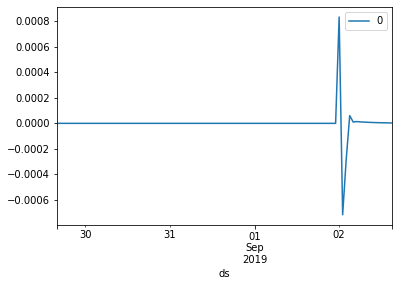

Now plotting the desity of the residual error values.


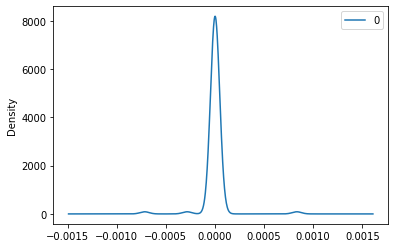

                  0
count  9.600000e+01
mean  -1.861660e-07
std    1.166326e-04
min   -7.161673e-04
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    8.333333e-04
                      predict
ds                           
2019-09-02 16:00:00 -0.000003
2019-09-02 17:00:00 -0.000004
2019-09-02 18:00:00 -0.000006
2019-09-02 19:00:00 -0.000008
2019-09-02 20:00:00 -0.000011
2019-09-02 21:00:00 -0.000013
2019-09-02 22:00:00 -0.000015
2019-09-02 23:00:00 -0.000017
2019-09-03 00:00:00  0.001648
2019-09-03 01:00:00 -0.000021
2019-09-03 02:00:00 -0.000023
2019-09-03 03:00:00 -0.000025
2019-09-03 04:00:00 -0.000027
2019-09-03 05:00:00 -0.000029
2019-09-03 06:00:00 -0.000031
2019-09-03 07:00:00 -0.000033
2019-09-03 08:00:00 -0.000035
2019-09-03 09:00:00 -0.000037
2019-09-03 10:00:00 -0.000039
2019-09-03 11:00:00 -0.000041
                       y
ds                      
2019-09-02 16:00:00  0.0
2019-09-02 17:00:00  0.0
2019-09-02 18:00:00  0.0
2019-09-02 19:00:00  0.0
2019-09-02

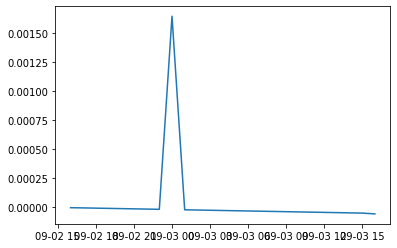

Now plotting the forecasted vs the test data.


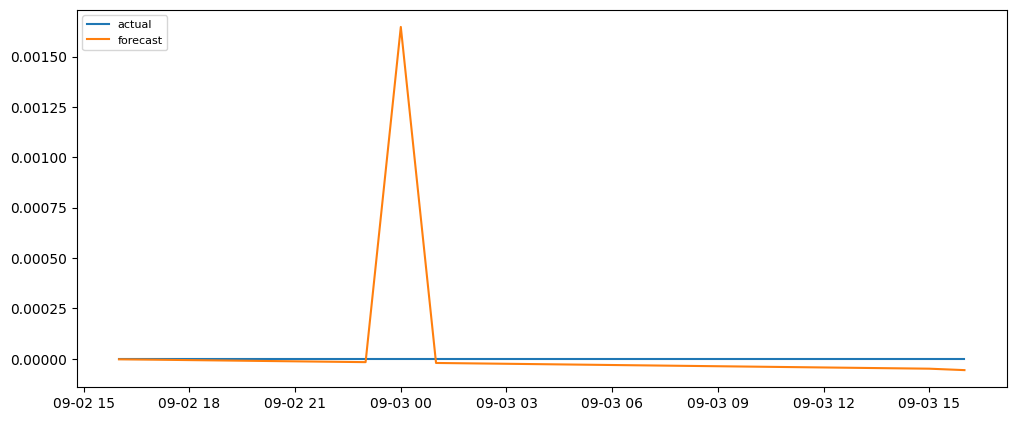

In [17]:
freq = '1h'
model, model_fit, forecast = sarima(train, test, freq)